<a href="https://colab.research.google.com/github/stevenfox/Pyspark_Nuclear_Classification/blob/master/Task_2_Distributed_Models_Spark_Nuclear_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task: Develop distributed models in Apache spark to classify nuclear reactors

The objective of this assessment is to analyse a large dataset concerning pressurised water reactor data, specifically on the properties involved in the fuel assemblies cluster vibrations, alterations of thermal and hydraulic parameters, etc. 

For over 70 years, the nuclear power industry – in the UK and worldwide – have primarily focused on the technological evolution of reliable nuclear power plants to produce electricity. 
By monitoring pressurised water reactors (a type of nuclear reactor), whilst operating at nominal conditions, it is possible to collect valuable insight and extract knowledge for early detection of abnormal events. Various types of fluctuations and perturbations can be caused by the turbulent nature of flow in the core, mechanical vibrations within the reactor, the boiling coolant and stochastic character (random noise). The dataset can be downloaded from MyAberdeen.

It is based on data from a research project that investigates how to detect anomalies and events in pressurised water reactors. The dataset includes two classes (normal/abnormal condition) and a number of features, which will need to be utilised throughout this assessment.  The class membership of each row is stored in the field ‘Status’. 

The task is to develop a set of classification models for automatically **classifying reactors** as normal or abnormal, based on their parameters/features. No prior knowledge of the domain problem is needed or assumed to fulfil the requirements of this assessment.

##1. Create Apache Spark Cluster Environment 
importing and installing  all the required files

In [1]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.6" 2020-01-14
OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)


In [0]:
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz

In [0]:
!tar xf spark-2.4.5-bin-hadoop2.7.tgz

In [0]:
!pip install -q findspark

In [5]:
#To find the GPU information allocated to play with run the below snippet of code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=6f7c62d7115b00d7a35a3dd750da39a37d82baf025c1069de5440223342ee1b3
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.7 GB  | Proc size: 159.7 MB
GPU RAM Free: 7611MB | Used: 0MB | Util   0% | Total 7611MB


In [0]:
import os
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
import findspark
findspark.init()

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Learning_Spark") \
    .getOrCreate()

##1.1 Various Statistics on Dataset

In [8]:
#read the file using spark read command
file_loc = 'dataset.csv'
data = spark.read.csv(file_loc, inferSchema=True, header=True)

# you may want to count the data and show them to understand what is all about
data.count()
data.first()

# print out the schema
data.schema


StructType(List(StructField(Status,StringType,true),StructField(Power_range_sensor_1,DoubleType,true),StructField(Power_range_sensor_2,DoubleType,true),StructField(Power_range_sensor_3 ,DoubleType,true),StructField(Power_range_sensor_4,DoubleType,true),StructField(Pressure _sensor_1,DoubleType,true),StructField(Pressure _sensor_2,DoubleType,true),StructField(Pressure _sensor_3,DoubleType,true),StructField(Pressure _sensor_4,DoubleType,true),StructField(Vibration_sensor_1,DoubleType,true),StructField(Vibration_sensor_2,DoubleType,true),StructField(Vibration_sensor_3,DoubleType,true),StructField(Vibration_sensor_4,DoubleType,true)))

In [9]:
data.count(), len(data.columns)

(996, 13)

In [10]:
data.show(5)

+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Status|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3 |Power_range_sensor_4|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Pressure _sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Normal|              4.5044|              0.7443|                 6.34|              1.9052|           29.5315|            0.8647|            2.2044|             6.048|           14.4659|            21.648|           15.3429|            1.2186|
|Normal|        

In [11]:
# remove_whitespace from columns
data.columns
data

DataFrame[Status: string, Power_range_sensor_1: double, Power_range_sensor_2: double, Power_range_sensor_3 : double, Power_range_sensor_4: double, Pressure _sensor_1: double, Pressure _sensor_2: double, Pressure _sensor_3: double, Pressure _sensor_4: double, Vibration_sensor_1: double, Vibration_sensor_2: double, Vibration_sensor_3: double, Vibration_sensor_4: double]

In [0]:
import pyspark.sql.functions as F

def remove_all_whitespace(col):
    return F.regexp_replace(col, "\\s+", "")

In [0]:
def remove_whitespace(data, _col):
  temp = colm.replace(" ", "")
  data = data.withColumnRenamed(_col , temp)
  # print(a)
  return data

In [0]:
for colm in data.columns:
  data = remove_whitespace(data, colm)  

In [15]:
data.printSchema()

root
 |-- Status: string (nullable = true)
 |-- Power_range_sensor_1: double (nullable = true)
 |-- Power_range_sensor_2: double (nullable = true)
 |-- Power_range_sensor_3: double (nullable = true)
 |-- Power_range_sensor_4: double (nullable = true)
 |-- Pressure_sensor_1: double (nullable = true)
 |-- Pressure_sensor_2: double (nullable = true)
 |-- Pressure_sensor_3: double (nullable = true)
 |-- Pressure_sensor_4: double (nullable = true)
 |-- Vibration_sensor_1: double (nullable = true)
 |-- Vibration_sensor_2: double (nullable = true)
 |-- Vibration_sensor_3: double (nullable = true)
 |-- Vibration_sensor_4: double (nullable = true)



In [16]:
data_features = data.drop("Status")
data_features.describe().show()

+-------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+
|summary|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3|Power_range_sensor_4| Pressure_sensor_1| Pressure_sensor_2| Pressure_sensor_3|Pressure_sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+-------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+
|  count|                 996|                 996|                 996|                 996|               996|               996|               996|              996|               996|               996|               996|               996|
|   mean|  4.9995738

In [17]:
# kota = data.schema.names
# kota_list = ', '.join(map(str, kota))[0:]

data_features.printSchema()

root
 |-- Power_range_sensor_1: double (nullable = true)
 |-- Power_range_sensor_2: double (nullable = true)
 |-- Power_range_sensor_3: double (nullable = true)
 |-- Power_range_sensor_4: double (nullable = true)
 |-- Pressure_sensor_1: double (nullable = true)
 |-- Pressure_sensor_2: double (nullable = true)
 |-- Pressure_sensor_3: double (nullable = true)
 |-- Pressure_sensor_4: double (nullable = true)
 |-- Vibration_sensor_1: double (nullable = true)
 |-- Vibration_sensor_2: double (nullable = true)
 |-- Vibration_sensor_3: double (nullable = true)
 |-- Vibration_sensor_4: double (nullable = true)



In [0]:
from pyspark.sql.functions import col

def calc_quantile(_data, _col, quantile_prob):
  _list_quant= []
  val = _data.approxQuantile(_col, [quantile_prob], 0.0)
  # print(val)
  # print(data.withColumn('Quantile', col(_col)))
  val
  # a= _data.withColumn(_col, col(_col))
  # a = _stat_table.union(val)
 

  # print(a.show())
  # print(quantiles)
  return val


In [0]:
def show_table_in_same_order(_prime, _target):
  rearranged_table = _prime.select(
      *(
          [
              col(t).cast(d) if t in _prime.columns else lit(None).alias(t) 
              for t, d in _target.dtypes
          ] +
          [s for s in _prime.columns if s not in _target.columns]
      )
  )


  rearranged_table.show()


In [82]:
import string
from pyspark.sql.functions import lit
from pyspark.sql.types import StringType
import pyspark.sql.functions as F
from pyspark.sql.functions import *



from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.sql.types import *
from pyspark.sql.functions import isnan, when, count, col

from pyspark.ml.classification import LogisticRegression, GBTClassifier
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

spark = SparkSession.builder.appName('abc').enableHiveSupport().getOrCreate()
sc = spark.sparkContext

probabilities = [0.25, 0.50, 0.75]

quantile_25 = []
quantile_50 = []
quantile_75 = []

data_f_stats = data_features.describe()
cols_data_f_stats = data_f_stats.columns

for colm in data_features.columns:
    quantile_25.append(calc_quantile(data_features, colm, probabilities[0]))

for colm in data_features.columns:
    quantile_50.append(calc_quantile(data_features, colm, probabilities[1]))

for colm in data_features.columns:
    quantile_75.append(calc_quantile(data_features, colm, probabilities[2]))

quantile_25.insert(0,'25%')
quantile_50.insert(0,'50%')
quantile_75.insert(0,'75%')


dic_25 = {}
dic_50 = {}
dic_75 = {}
i=0
for cola in cols_data_f_stats:
    dic_25.update({cola: quantile_25[i]})
    dic_50.update({cola: quantile_50[i]})
    dic_75.update({cola: quantile_75[i]})
    i+=1

rdd_25 = sc.parallelize([dic_25])
q_25 = spark.read.json(rdd_25)


rdd_50 = sc.parallelize([dic_50])
q_50 = spark.read.json(rdd_50)

rdd_75 = sc.parallelize([dic_75])
q_75 = spark.read.json(rdd_75)


dq = q_25.union(q_50)
dq_all = dq.union(q_75)



data_f_stats.show()
show_table_in_same_order(dq_all, data_f_stats)




+-------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+
|summary|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3|Power_range_sensor_4| Pressure_sensor_1| Pressure_sensor_2| Pressure_sensor_3|Pressure_sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+-------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+
|  count|                 996|                 996|                 996|                 996|               996|               996|               996|              996|               996|               996|               996|               996|
|   mean|  4.9995738

In [21]:
data_features.printSchema()

root
 |-- Power_range_sensor_1: double (nullable = true)
 |-- Power_range_sensor_2: double (nullable = true)
 |-- Power_range_sensor_3: double (nullable = true)
 |-- Power_range_sensor_4: double (nullable = true)
 |-- Pressure_sensor_1: double (nullable = true)
 |-- Pressure_sensor_2: double (nullable = true)
 |-- Pressure_sensor_3: double (nullable = true)
 |-- Pressure_sensor_4: double (nullable = true)
 |-- Vibration_sensor_1: double (nullable = true)
 |-- Vibration_sensor_2: double (nullable = true)
 |-- Vibration_sensor_3: double (nullable = true)
 |-- Vibration_sensor_4: double (nullable = true)



In [83]:
# from pyspark.sql.functions import isnan, when, count, col

data_features.select([count(when(isnan(c), c)).alias(c) for c in data_features.columns]).show()

+--------------------+--------------------+--------------------+--------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+
|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3|Power_range_sensor_4|Pressure_sensor_1|Pressure_sensor_2|Pressure_sensor_3|Pressure_sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+--------------------+--------------------+--------------------+--------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+
|                   0|                   0|                   0|                   0|                0|                0|                0|                0|                 0|                 0|                 0|                 0|
+--------------------+--------------------+--------------------+

##2. Visualisation


###2.1 Box Plot

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
data_df = data.toPandas()

In [88]:
# Display the number of Status of each state

data.groupBy("Status").count().show()

+--------+-----+
|  Status|count|
+--------+-----+
|Abnormal|  498|
|  Normal|  498|
+--------+-----+



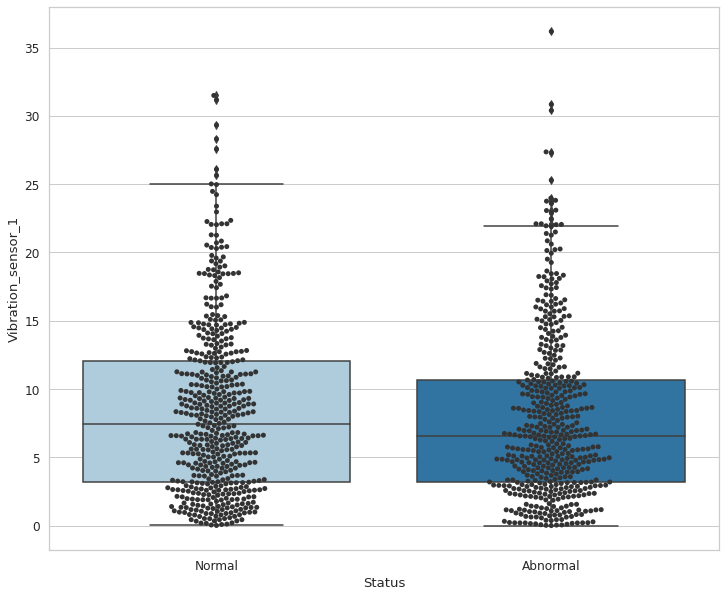

In [85]:
sns.set(style='whitegrid', palette="Paired", font_scale=1, rc={"figure.figsize": [12, 10]})
ax = sns.boxplot(x="Status", y="Vibration_sensor_1", data=data_df, dodge=False)
ax = sns.swarmplot(x="Status", y="Vibration_sensor_1", data=data_df, color=".2")
plt.show()

###2.2 Distribution Plot

In [0]:
# Filter values
normal_status = data_df[data_df['Status'] == 'Normal']
abnormal_status = data_df[data_df['Status'] == 'Abnormal']

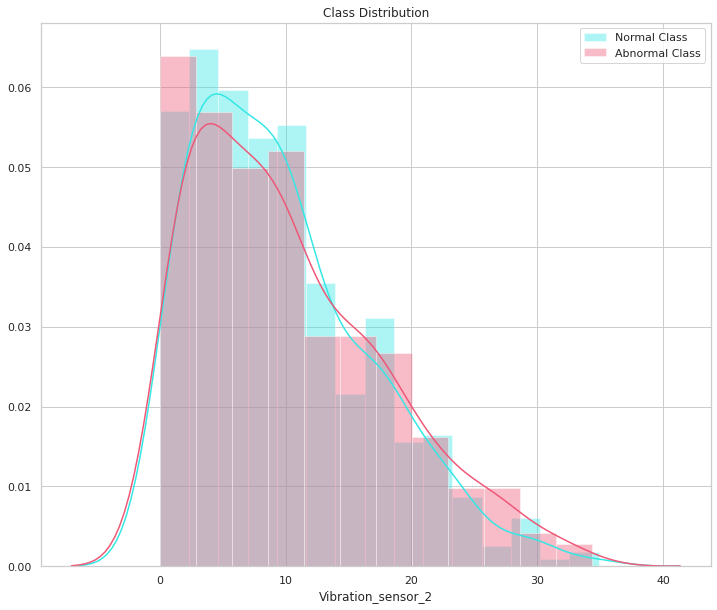

In [148]:

sns.set(style='whitegrid', font_scale=1, rc={"figure.figsize": [12, 10]})
flatui = ["#34e7e4","#ef5777"]
sns.set_palette(flatui)
sns.distplot(normal_status['Vibration_sensor_2'], label='Normal Class').set_title('Class Distribution')
sns.distplot(abnormal_status['Vibration_sensor_2'], label='Abnormal Class')
plt.legend()
plt.show()

# Logistic Regression Classification
Develop and train a binary logistic regression model to classify the condition of nuclear reactors, i.e. normal or abnormal, based on how they operate. Split the dataset provided into a training (75%) and test (25%) sets.
